# Lectura y Análisis

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [24]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [25]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
# start_date = "2024-03-01"
# end_date = "2025-02-28"
start_date = "2025-03-01"
end_date = "2025-03-30"

location = "garachico"

grafcan = "grafcan_garachico"
openmeteo_arpege = "openmeteo_garachico_arpege"
openmeteo_icon = "openmeteo_garachico_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_garachico...
air_temperature           7.940038
atmospheric_pressure    914.151825
relative_humidity        84.254725
Name: 2025-03-01 00:00:00+00:00, dtype: float64
air_temperature          12.692410
atmospheric_pressure    909.160522
relative_humidity        72.572500
Name: 2025-03-30 23:00:00+00:00, dtype: float64
Processing openmeteo_garachico_arpege...
air_temperature          11.0
atmospheric_pressure    913.3
relative_humidity        71.0
Name: 2025-03-01 00:00:00+00:00, dtype: float64
air_temperature          12.6
atmospheric_pressure    909.6
relative_humidity        65.0
Name: 2025-03-30 23:00:00+00:00, dtype: float64
Processing openmeteo_garachico_icon...
air_temperature          10.2
atmospheric_pressure    914.3
relative_humidity        81.0
Name: 2025-03-01 00:00:00+00:00, dtype: float64
air_temperature          12.8
atmospheric_pressure    909.6
relative_humidity        70.0
Name: 2025-03-30 23:00:00+00:00, dtype: float64


## Visualización

In [26]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

Plotting air_temperature


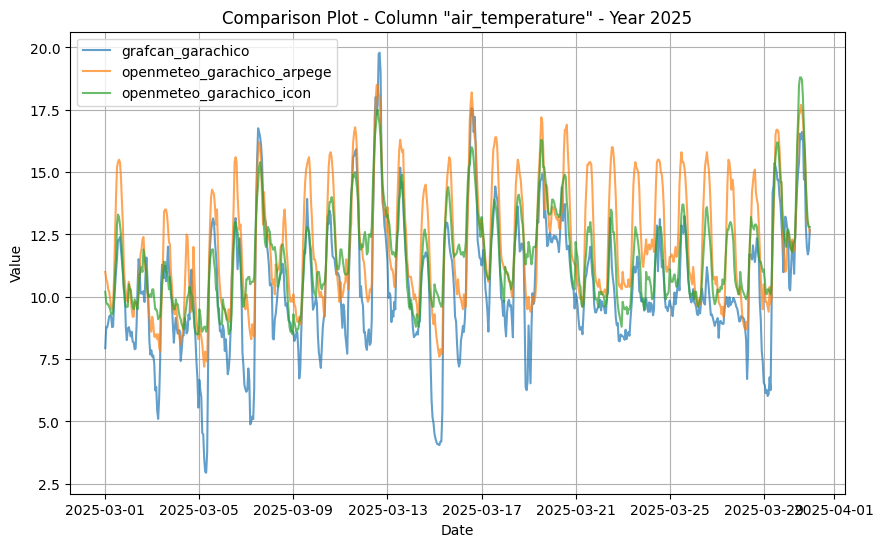

Plotting relative_humidity


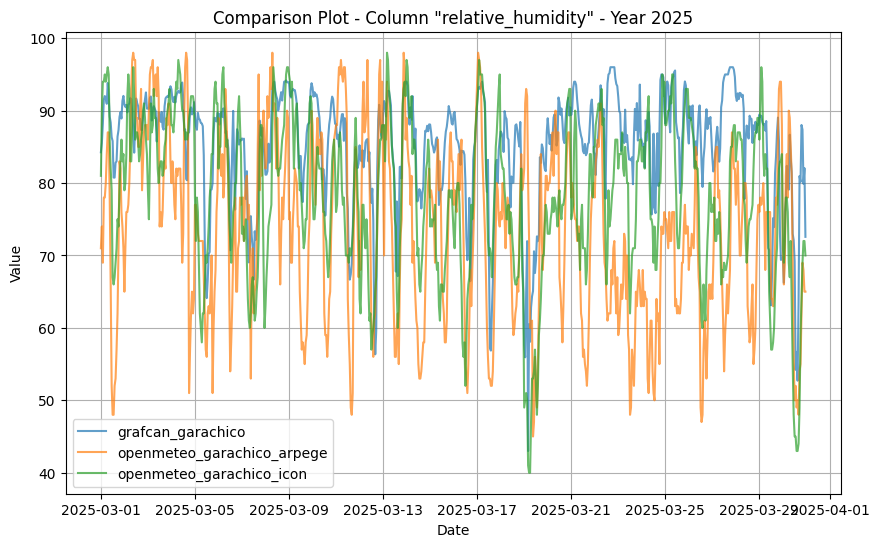

Plotting atmospheric_pressure


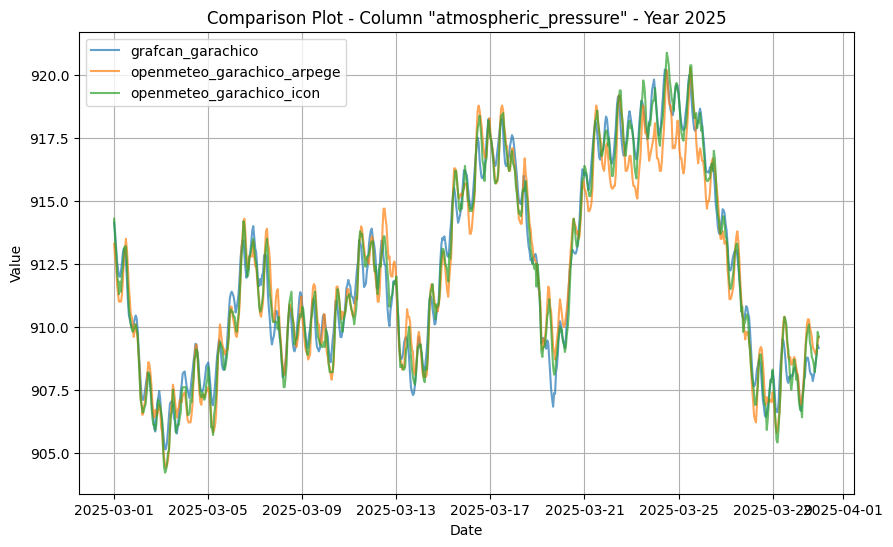

In [27]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [28]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

No missing hours in grafcan_garachico after resampling.
No missing hours in openmeteo_garachico_arpege after resampling.
No missing hours in openmeteo_garachico_icon after resampling.


### Manejo Horas faltantes

In [29]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= threshold hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [30]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [31]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [32]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_garachico_icon vs grafcan_garachico
  air_temperature:
    Pearson: 0.8240
    Spearman: 0.8107
    Kendall: 0.6295
    MSE: 3.4736
    Euclidean Distance: 50.0097
  atmospheric_pressure:
    Pearson: 0.9866
    Spearman: 0.9828
    Kendall: 0.8941
    MSE: 0.4202
    Euclidean Distance: 17.3934
  relative_humidity:
    Pearson: 0.6786
    Spearman: 0.6508
    Kendall: 0.4747
    MSE: 113.8314
    Euclidean Distance: 286.2842


In [33]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_garachico_arpege vs grafcan_garachico
  air_temperature:
    Pearson: 0.8595
    Spearman: 0.8694
    Kendall: 0.6879
    MSE: 4.4492
    Euclidean Distance: 56.5990
  atmospheric_pressure:
    Pearson: 0.9675
    Spearman: 0.9658
    Kendall: 0.8395
    MSE: 0.9785
    Euclidean Distance: 26.5428
  relative_humidity:
    Pearson: 0.3726
    Spearman: 0.3626
    Kendall: 0.2482
    MSE: 276.1564
    Euclidean Distance: 445.9065


### Selección de datasets

In [34]:
new_df_openmeteo = "openmeteo_" + location
dataframes[new_df_openmeteo] = dataframes[openmeteo_icon].copy()

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [35]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_garachico:


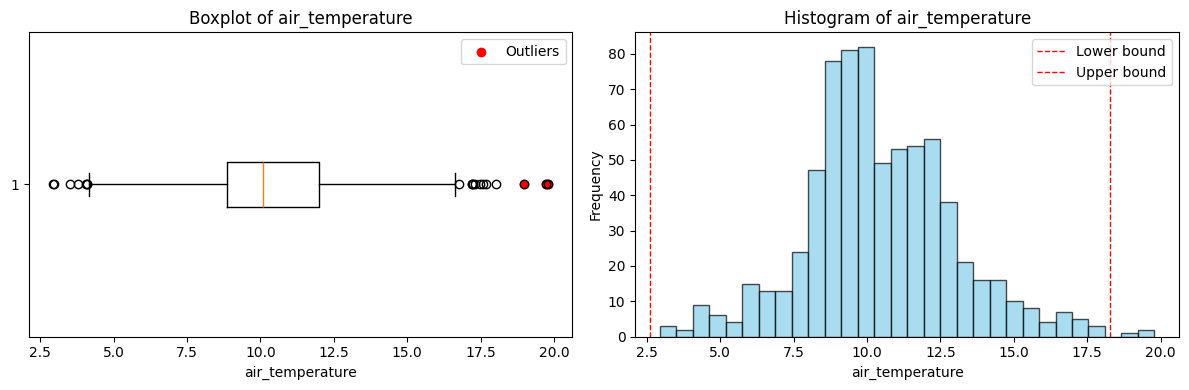

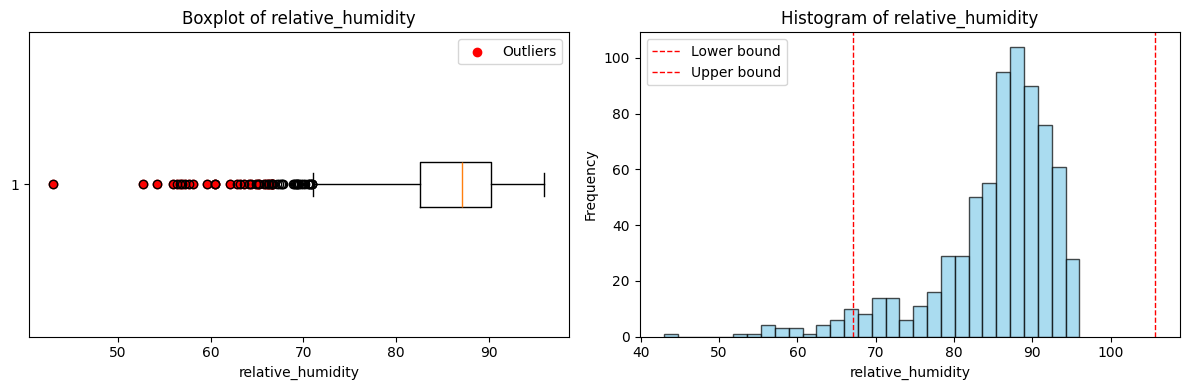

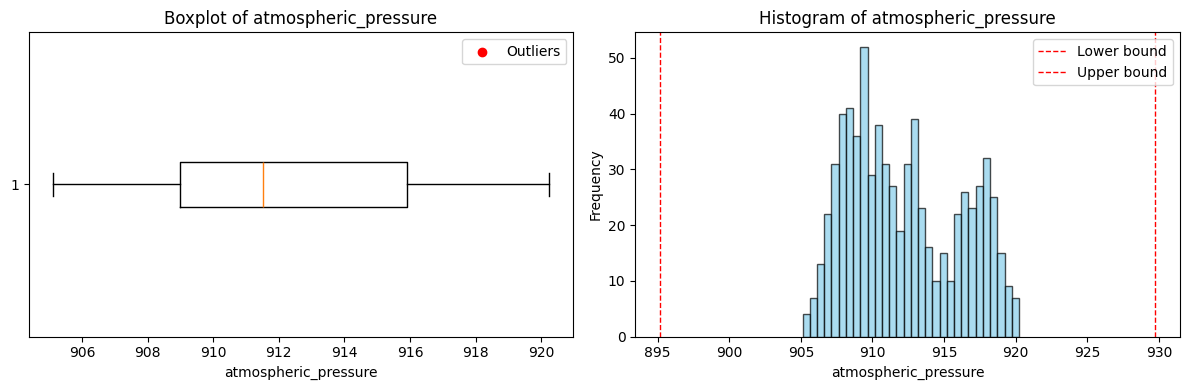

  air_temperature outlier row indices: [Timestamp('2025-03-12 15:00:00+0000', tz='UTC'), Timestamp('2025-03-12 16:00:00+0000', tz='UTC'), Timestamp('2025-03-12 17:00:00+0000', tz='UTC')]
  relative_humidity outlier row indices: [Timestamp('2025-03-05 11:00:00+0000', tz='UTC'), Timestamp('2025-03-05 12:00:00+0000', tz='UTC'), Timestamp('2025-03-05 13:00:00+0000', tz='UTC'), Timestamp('2025-03-07 12:00:00+0000', tz='UTC'), Timestamp('2025-03-11 14:00:00+0000', tz='UTC'), Timestamp('2025-03-12 15:00:00+0000', tz='UTC'), Timestamp('2025-03-12 16:00:00+0000', tz='UTC'), Timestamp('2025-03-12 17:00:00+0000', tz='UTC'), Timestamp('2025-03-16 17:00:00+0000', tz='UTC'), Timestamp('2025-03-17 13:00:00+0000', tz='UTC'), Timestamp('2025-03-17 14:00:00+0000', tz='UTC'), Timestamp('2025-03-17 15:00:00+0000', tz='UTC'), Timestamp('2025-03-17 16:00:00+0000', tz='UTC'), Timestamp('2025-03-18 23:00:00+0000', tz='UTC'), Timestamp('2025-03-19 00:00:00+0000', tz='UTC'), Timestamp('2025-03-19 01:00:00+0000'

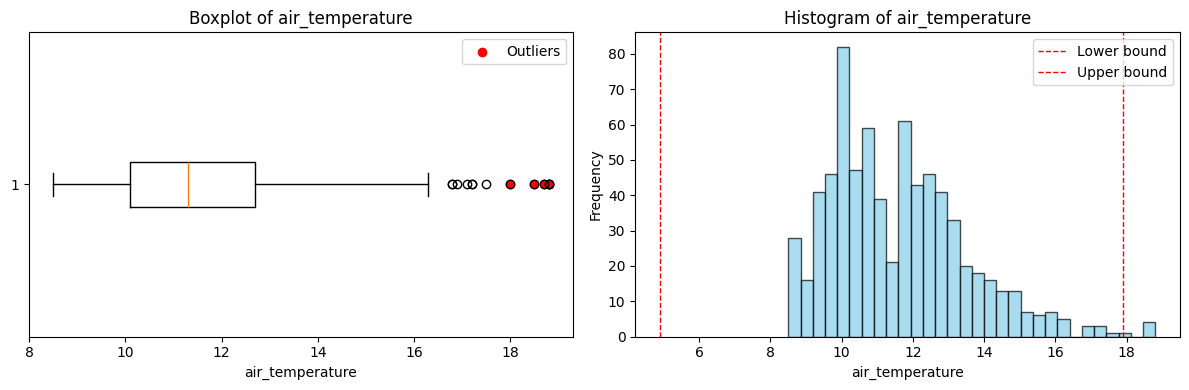

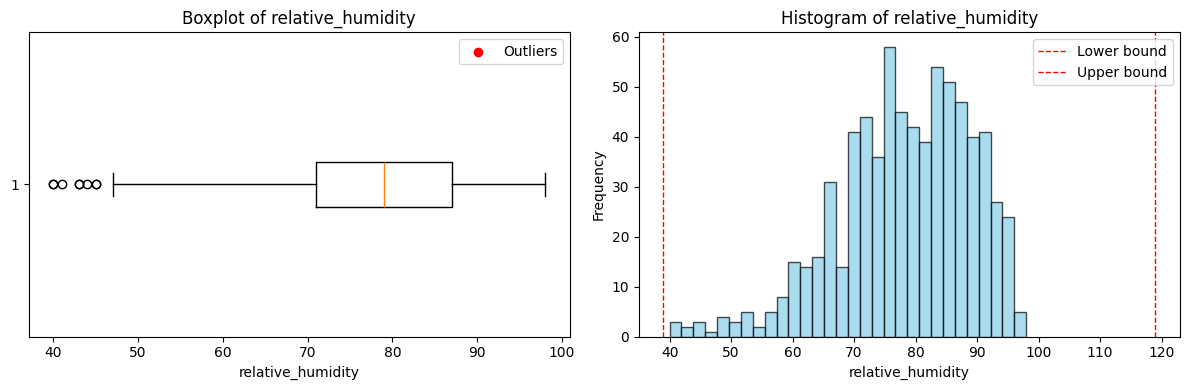

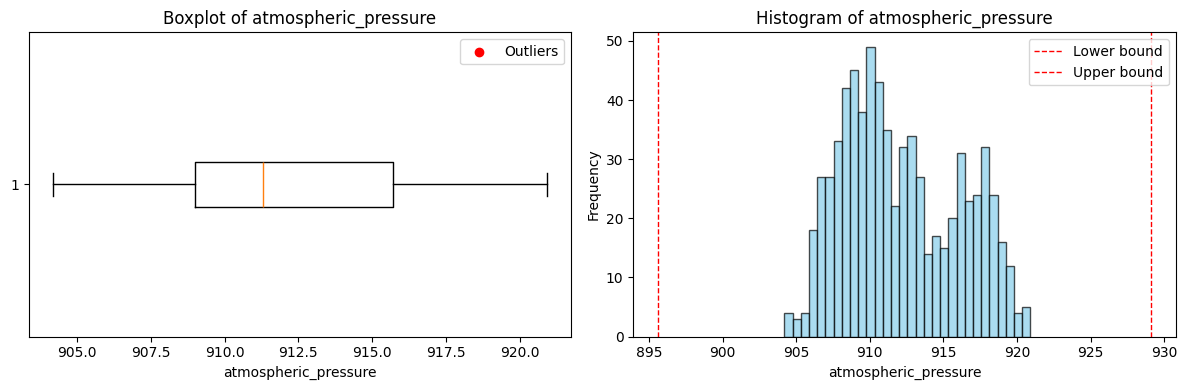

  air_temperature outlier row indices: [Timestamp('2025-03-30 12:00:00+0000', tz='UTC'), Timestamp('2025-03-30 13:00:00+0000', tz='UTC'), Timestamp('2025-03-30 14:00:00+0000', tz='UTC'), Timestamp('2025-03-30 15:00:00+0000', tz='UTC'), Timestamp('2025-03-30 16:00:00+0000', tz='UTC')]
  relative_humidity outlier row indices: []
  atmospheric_pressure outlier row indices: []
Detected 5 rows with outliers from openmeteo_garachico.



In [36]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_garachico for KNN outlier detection...
air_temperature


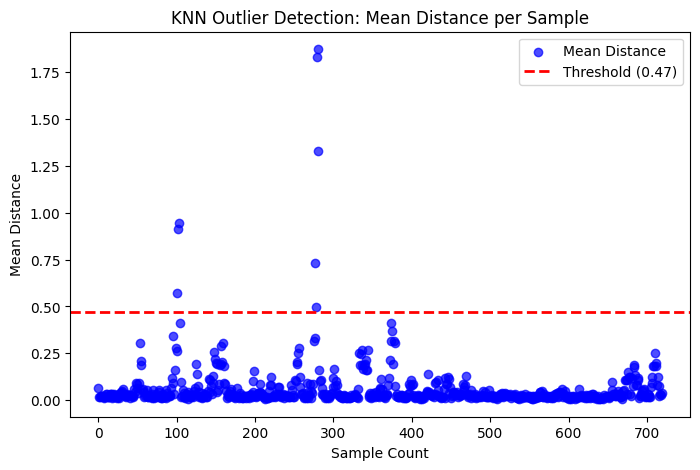

Detected 8 outliers at indices: [101 102 103 276 278 279 280 281]
atmospheric_pressure


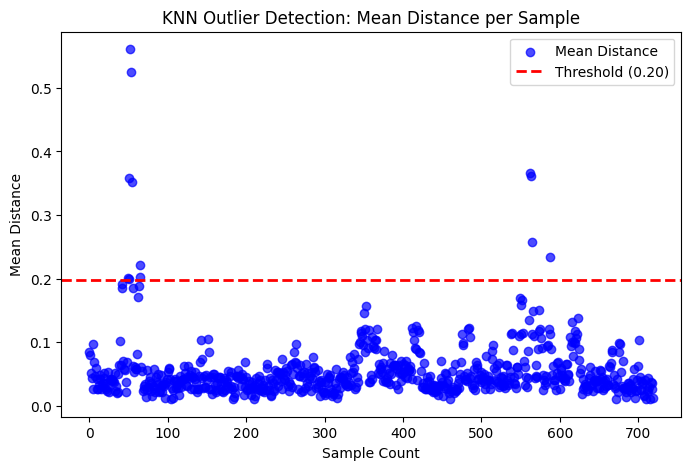

Detected 12 outliers at indices: [ 49  50  51  52  53  54  64  65 562 563 564 587]
relative_humidity


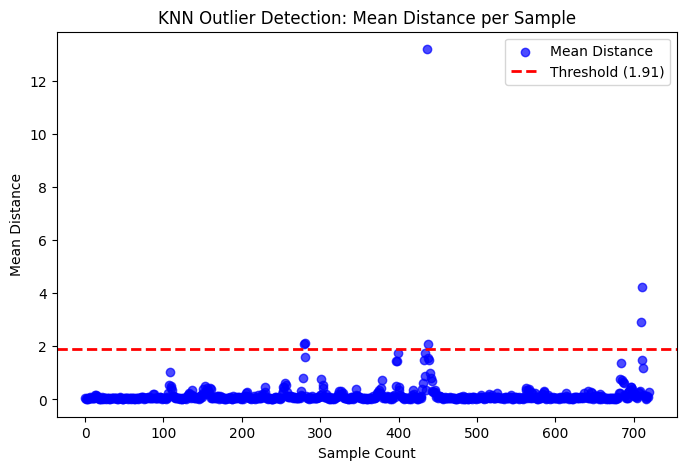

Detected 6 outliers at indices: [279 281 436 437 709 711]
Processing openmeteo_garachico for KNN outlier detection...
air_temperature


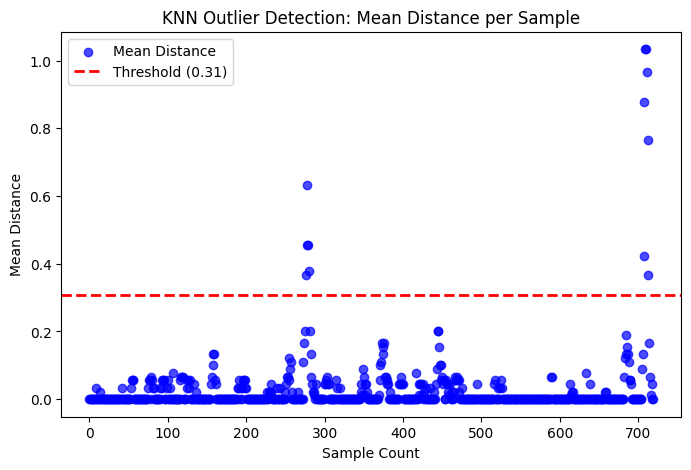

Detected 12 outliers at indices: [276 277 278 279 280 707 708 709 710 711 712 713]
atmospheric_pressure


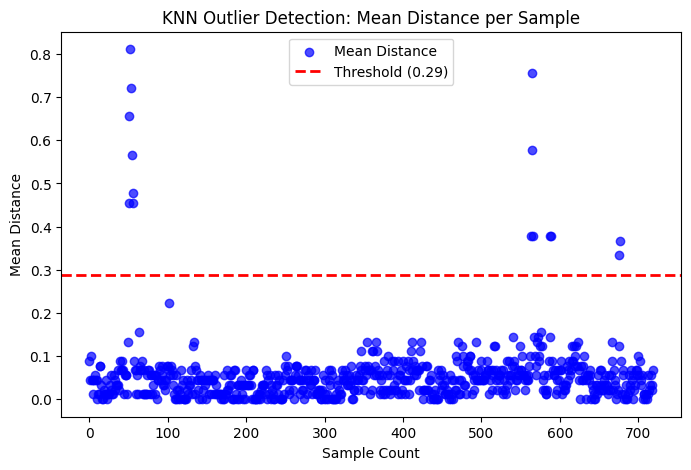

Detected 15 outliers at indices: [ 50  51  52  53  54  55  56 563 564 565 566 588 589 676 677]
relative_humidity


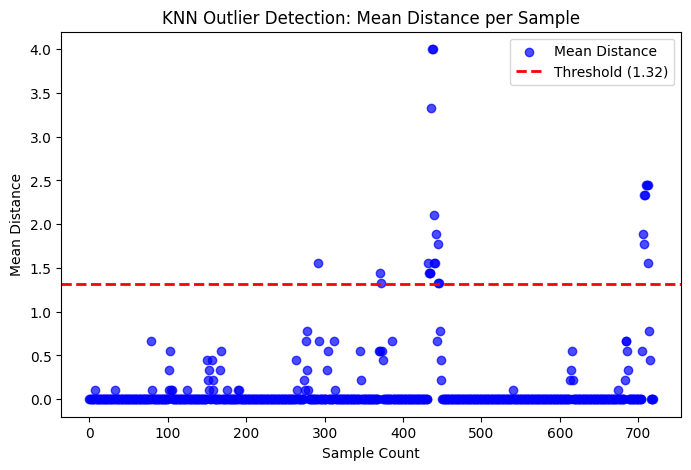

Detected 25 outliers at indices: [292 370 372 432 433 434 435 436 437 438 439 440 441 442 444 445 446 706
 707 708 709 710 711 712 713]


In [37]:
def knn_outlier_detection(data, k=10, threshold=3):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_garachico...


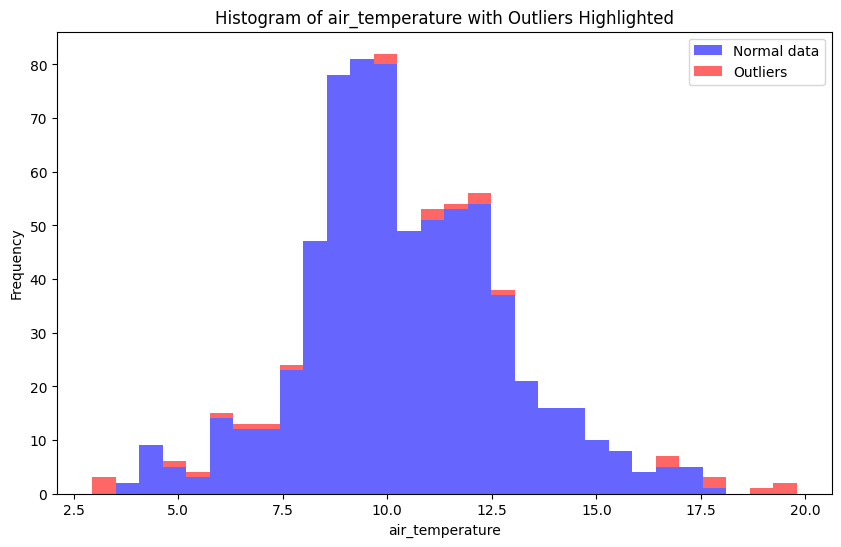

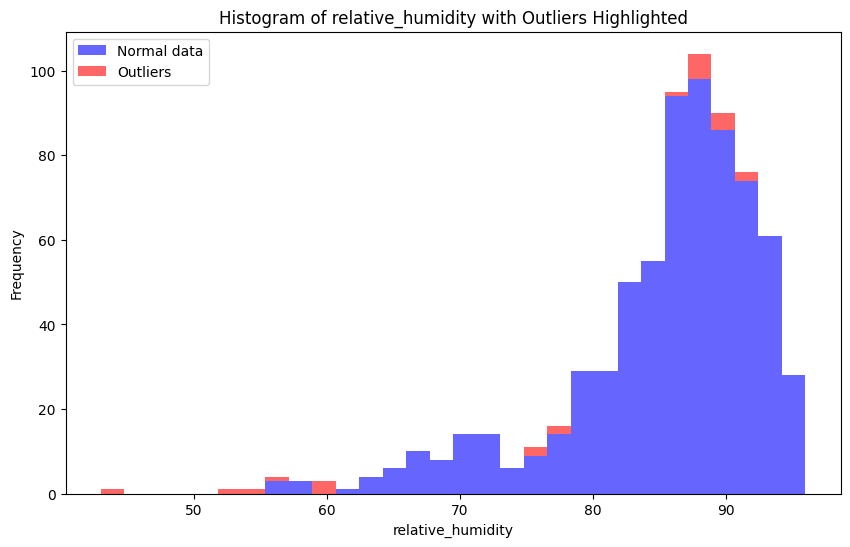

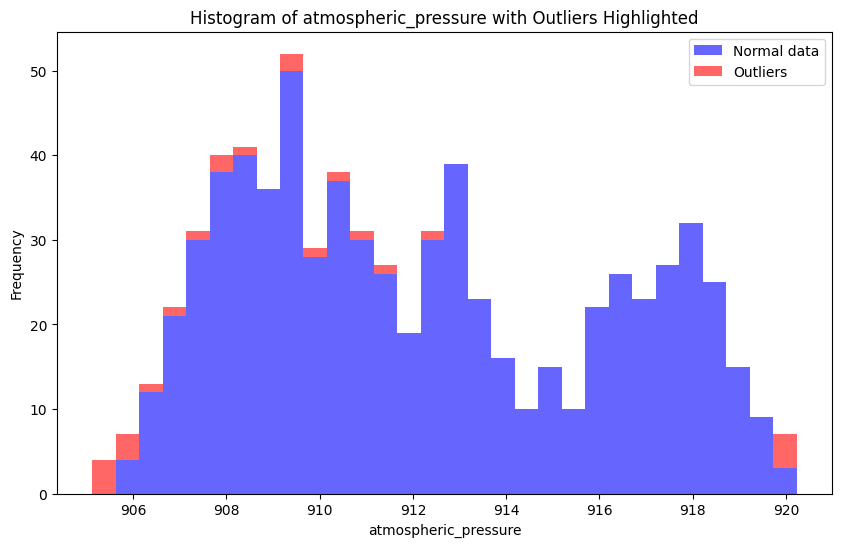

Plotting histogram for openmeteo_garachico...


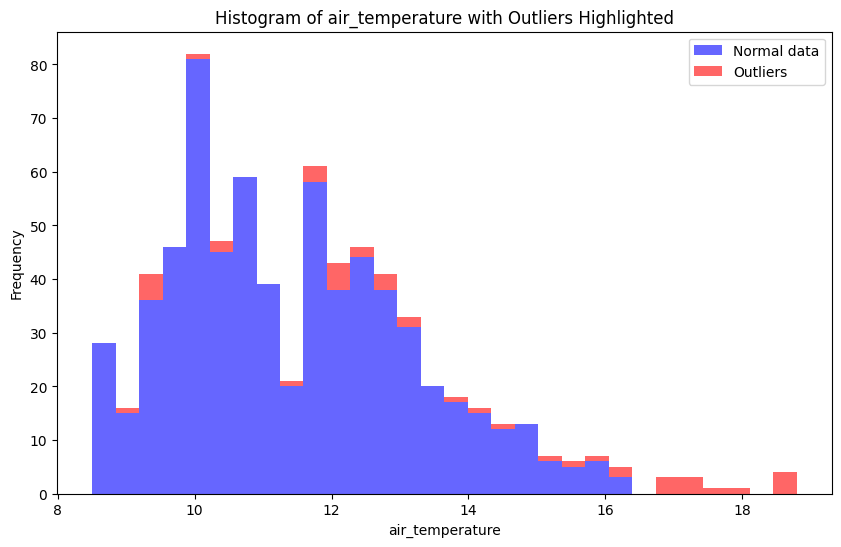

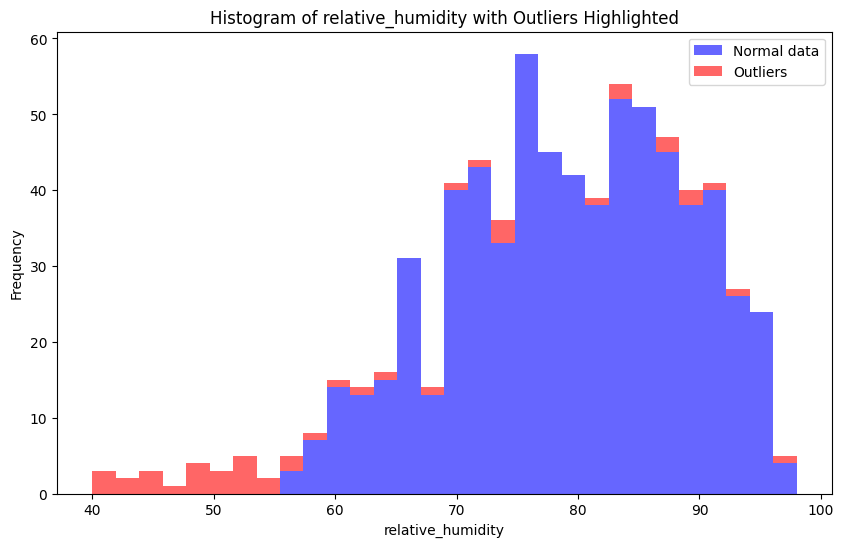

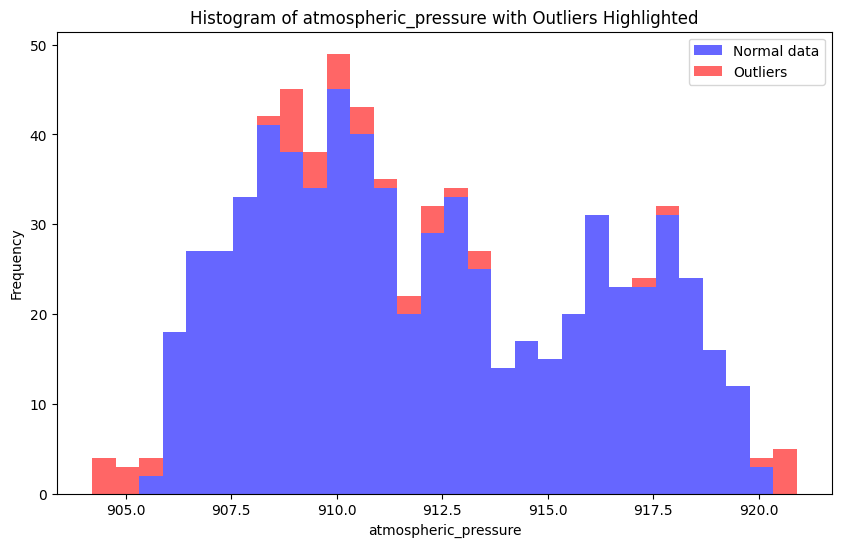

In [38]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [39]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_garachico...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000347 Hz, Period: 80.00 hours, Magnitude: 245.0565
Frequency: 0.00000116 Hz, Period: 240.00 hours, Magnitude: 293.6869
Frequency: 0.00000270 Hz, Period: 102.86 hours, Magnitude: 306.8947
Frequency: 0.00000193 Hz, Period: 144.00 hours, Magnitude: 324.9276
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 851.9759


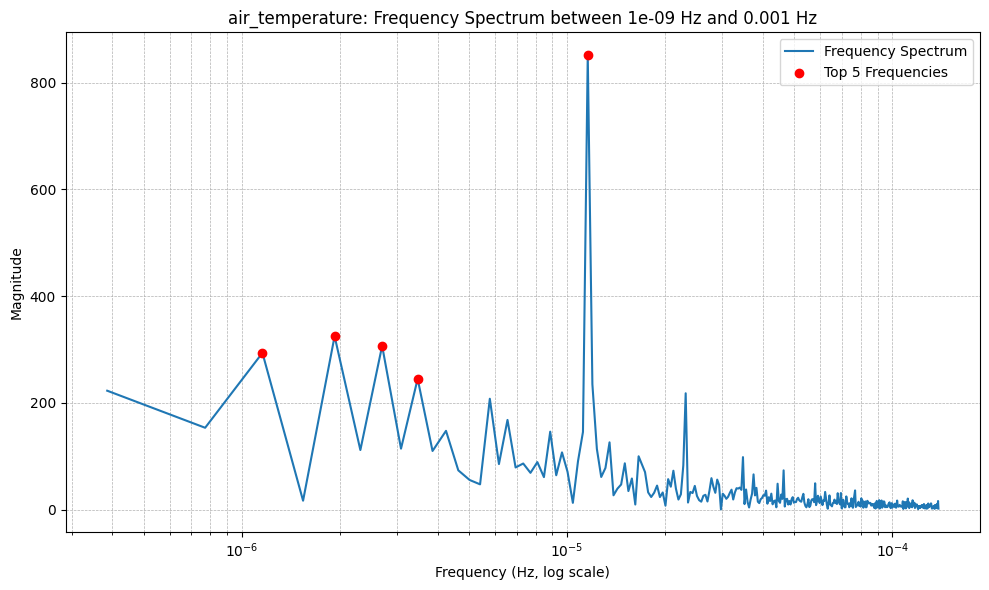

Top 5 frequencies with highest magnitude:
Frequency: 0.00000309 Hz, Period: 90.00 hours, Magnitude: 802.6898
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 830.1626
Frequency: 0.00000502 Hz, Period: 55.38 hours, Magnitude: 902.0396
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 1320.4978
Frequency: 0.00000193 Hz, Period: 144.00 hours, Magnitude: 1538.8312


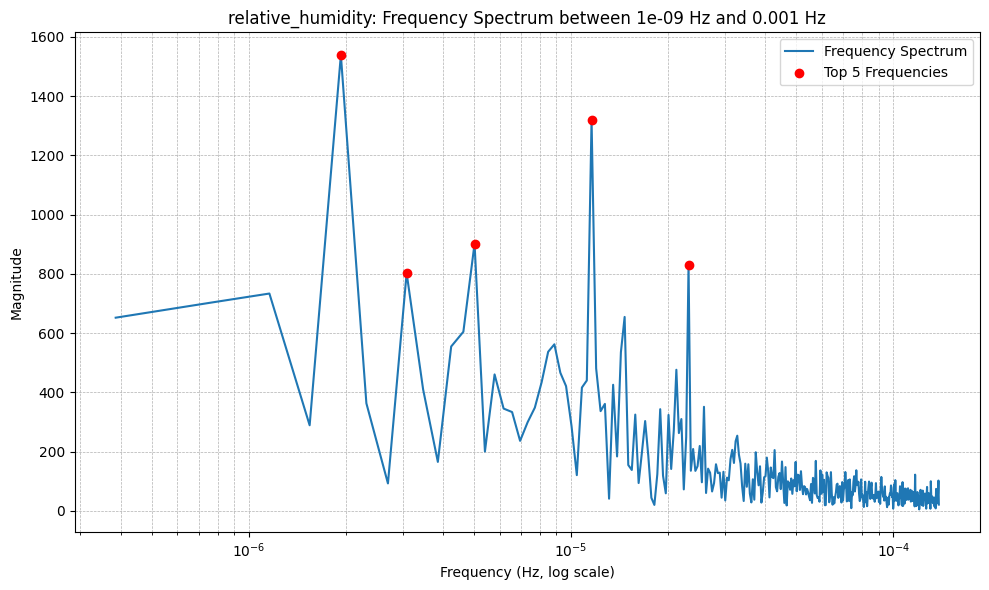

Top 5 frequencies with highest magnitude:
Frequency: 0.00000116 Hz, Period: 240.00 hours, Magnitude: 574.6417
Frequency: 0.00000154 Hz, Period: 180.00 hours, Magnitude: 619.9906
Frequency: 0.00000077 Hz, Period: 360.00 hours, Magnitude: 665.9641
Frequency: 0.00000231 Hz, Period: 120.00 hours, Magnitude: 677.3288
Frequency: 0.00000039 Hz, Period: 720.00 hours, Magnitude: 1338.2569


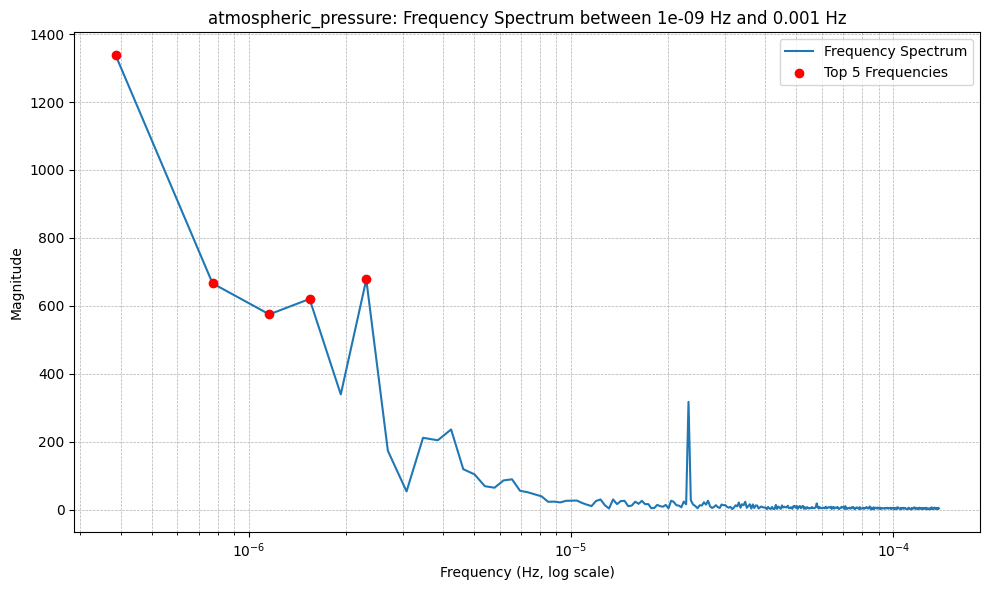

Plotting frequencies for openmeteo_garachico...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000270 Hz, Period: 102.86 hours, Magnitude: 262.9609
Frequency: 0.00000193 Hz, Period: 144.00 hours, Magnitude: 267.1559
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 283.8480
Frequency: 0.00000116 Hz, Period: 240.00 hours, Magnitude: 301.8748
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 544.5180


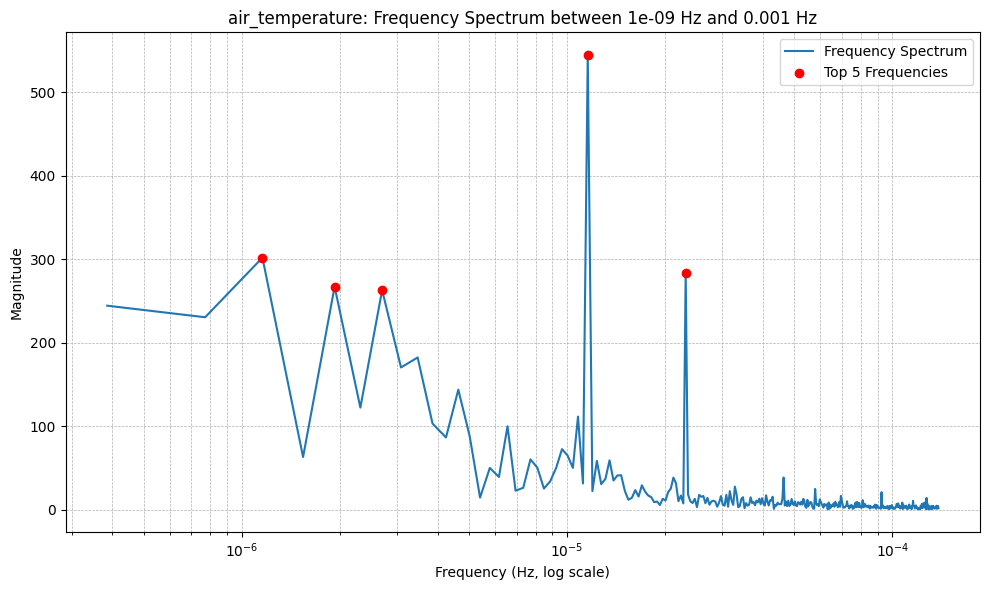

Top 5 frequencies with highest magnitude:
Frequency: 0.00000502 Hz, Period: 55.38 hours, Magnitude: 1258.1234
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 1269.3233
Frequency: 0.00000116 Hz, Period: 240.00 hours, Magnitude: 1312.1008
Frequency: 0.00000309 Hz, Period: 90.00 hours, Magnitude: 1926.7632
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 2468.6404


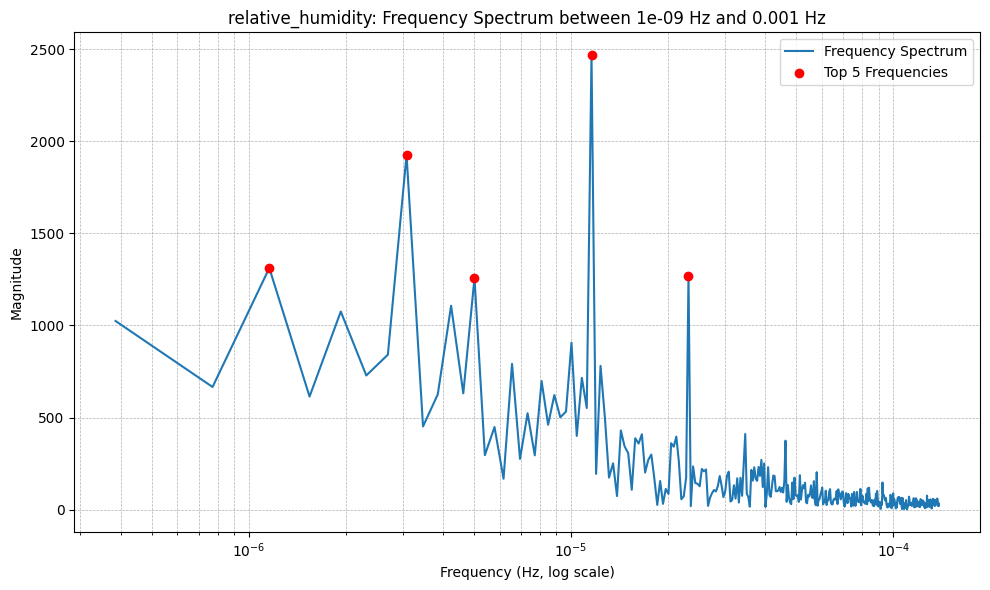

Top 5 frequencies with highest magnitude:
Frequency: 0.00000116 Hz, Period: 240.00 hours, Magnitude: 539.3012
Frequency: 0.00000154 Hz, Period: 180.00 hours, Magnitude: 629.4970
Frequency: 0.00000077 Hz, Period: 360.00 hours, Magnitude: 668.2935
Frequency: 0.00000231 Hz, Period: 120.00 hours, Magnitude: 669.3796
Frequency: 0.00000039 Hz, Period: 720.00 hours, Magnitude: 1384.6724


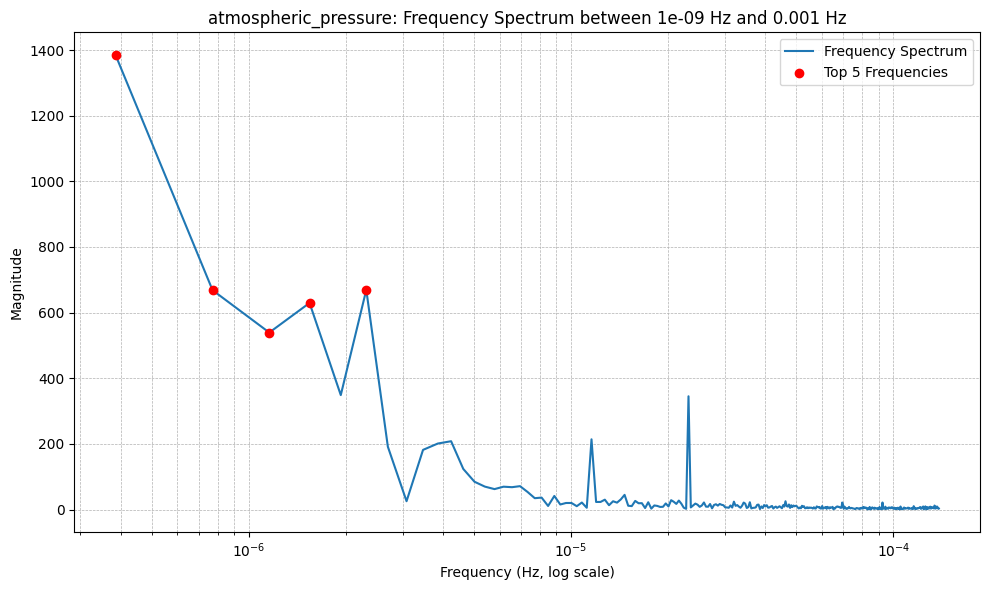

In [40]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [41]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_garachico...


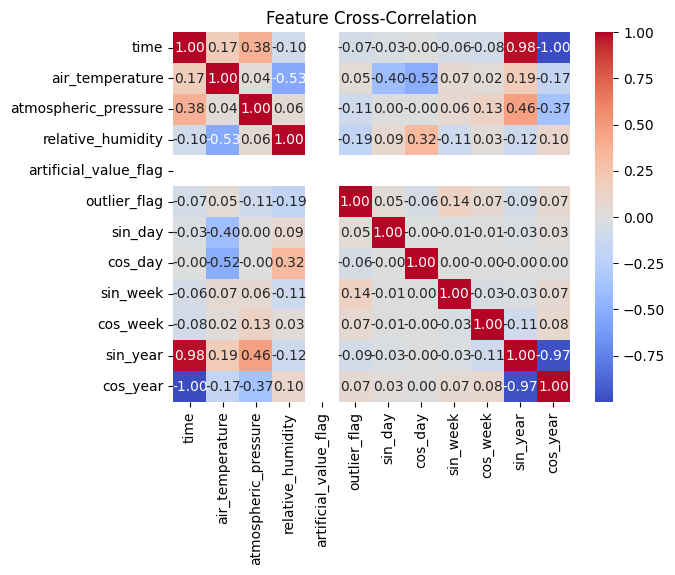

Plotting correlations for openmeteo_garachico...


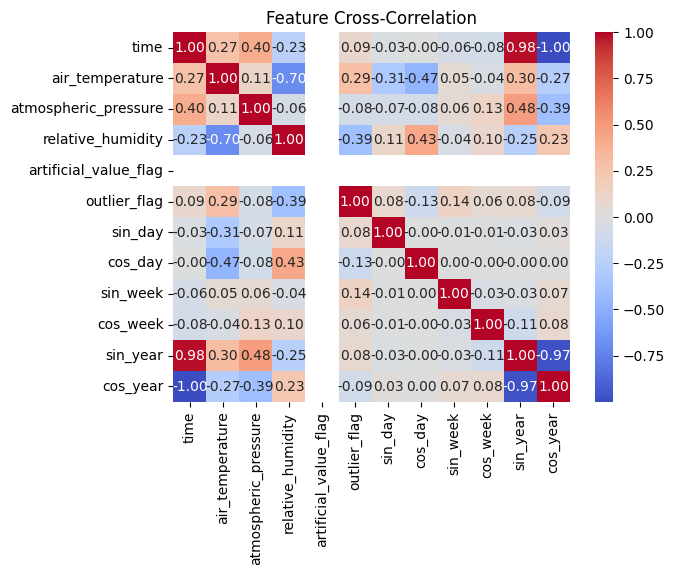

In [42]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [43]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [44]:
for name, df in dataframes.items():
  # df.to_csv("processed_data/" + name + "_features.csv", index=False)
  df.to_csv("test_data/" + name + "_features.csv", index=False)